In [1]:
import torch
from utils import load_vocab
from rnn import RNN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
vlist, vdict = load_vocab()

In [3]:
model = RNN(len(vlist), 8, 64)
model.load_state_dict(torch.load('checkpoints/checkpoint999.pt', map_location = torch.device('cpu')))
sum(x.numel() for x in model.parameters() if x.requires_grad)

22010

In [4]:
lst = TSNE(n_components=2).fit_transform(model.embed.weight.data)

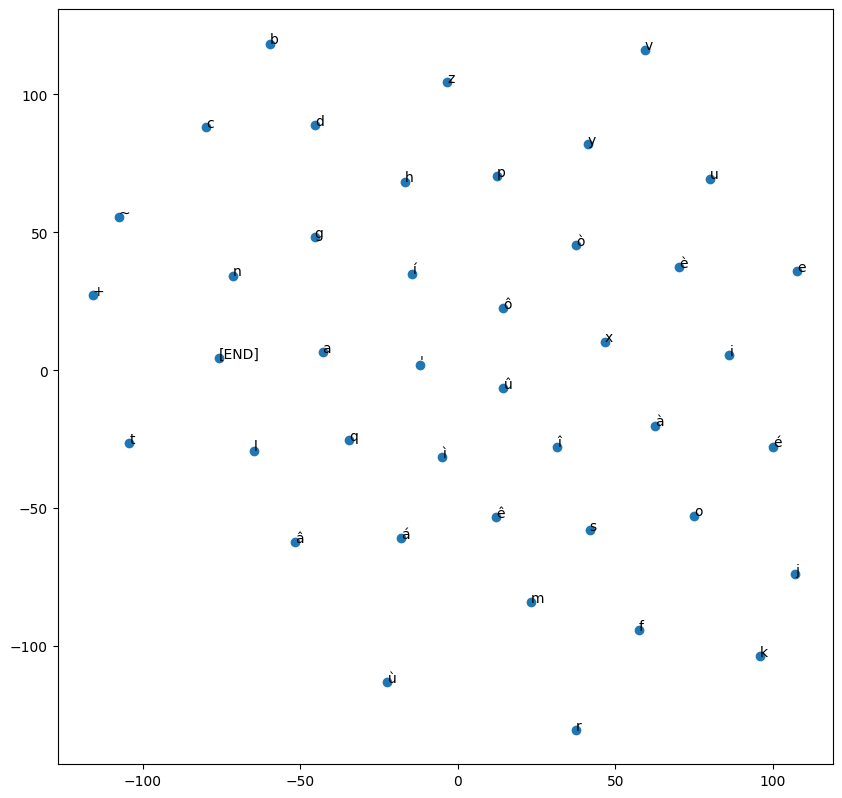

In [5]:
plt.figure(figsize=(10,10), dpi=100)
plt.scatter(lst[:,0], lst[:,1])
for i, (x, y) in enumerate(lst):
    plt.annotate(vlist[i], (x, y))
plt.show()

In [6]:
from torch.nn.utils.rnn import pad_sequence as pad

In [7]:
class BeamSearch:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        
    def calc_dist(self, beam):
        src = [torch.tensor(sent) for prob, sent in beam]
        with torch.no_grad():
            y = self.model({'src':pad(src), 'len':torch.tensor([len(x) for x in src])})
        y = y.permute(1, 0, 2)
        y = y[:, -1]
        y = y + y.new(y.size()).normal_(0, 0.5)
        y = torch.log_softmax(y, dim=-1)
        return y
    
    def cand(self, prob, sent, dist):
        values, indices = dist.topk(self.width)
        return [(prob + v.item(), sent + [i.item()]) for v, i in zip(values, indices)]
    
    def calc_cands(self, beam, dists):
        cands = [
            tup
            for (prob, sent), dist in zip(beam, dists)
            for tup in self.cand(prob, sent, dist)
        ]
        cands.sort(reverse=True)
        return cands[:self.width]
    
    def calc_beam(self, cands):
        beam = []
        for prob, sent in cands:
            if sent[-1] == 0:
                self.width -= 1
                self.output.append((prob, sent))
            else:
                beam.append((prob, sent))
        return beam
    
    def calc_output(self, init):
        beam = [(0, [0] + init)]
        for i in range(self.max_len):
            if self.width == 0:
                break
            dists = self.calc_dist(beam)
            cands = self.calc_cands(beam, dists)
            beam = self.calc_beam(cands)
            
    def search(self, width, init=[], max_len=10):
        self.width = width
        self.max_len = max_len
        self.output = []
        self.calc_output(init)
        return self.output
    
bs = BeamSearch(model)
words = []
for i in range(30):
    lst = bs.search(20)
    for prob, sent in lst:
        words.append(''.join([vlist[x] for x in sent[1:-1]]))
words = list(set(words) - set(''))
words.sort(key=len)
print('生成した語')
print(' '.join(words))

with open('dict.txt') as f:
    dct = set(f.read().splitlines())
words = list(set(words) - dct)
words.sort(key=len)
print('そのうち辞書にない語')
print(' '.join(words))

生成した語
li le vo ra hál ted xer xok deq lok tis kel cil rif caf zif ref zis xel sox zel lin kos taq rac hax cik tol tik lek kol vis yis raf dok vol sod sok hif fev kal xay cav dal def lot kut xal kez lof dol lev loc haf xaf ked doq sal tul xod sol fos ric vol~ fete lede kade soke voku sal~ solos litiv felom fecaq calet xolol catad kalev zifis lofet xayet tedac laket folit lisik sovas sokel cadek xolos tolok rafet qinet delik rafef talet xolas felos litiz deris kolod felok fesit titik celek fetaz cavos tiqil fetak maric pafem takud tilik dekol citit kodet levas delit fecak felac fetal tedem folos lisok tadek deqot debet felak tilas liqik tiliv cavol cakol liqiz fenit solok soket fetek sakal yelic livek sodil liqil rihal solak lifek rasaf ricat risaf valot qosot cakos sodel zelom cafek rafec fetil lisit levem qolec ledet palem beneg qolem solot likev kadet socak felat xolak yeras calot calit cafet soval sokad solat kutiq voqul delef tazis sokak sokal levac tedec dekuz tolék rafas linit tol